### Imports

In [37]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils_go import *

import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys

# %load_ext autotime

### Parameters

In [38]:
file = open("exp.json")
experiment = json.load(file)
exp_num = experiment["exp"]

file = open("output/{}/parameters.json".format(exp_num))
params = json.load(file)

exp = params["exp"]
print("Exp:\t\t", exp)

methods = params["methods"]
print("Methods:\t", methods)

data_variations = params["data_variations"]
print("Data variations:", data_variations)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

Exp:		 exp11
Methods:	 ['vgae-base']
Data variations: ['str']
Groups id:	 ['HN', 'HV']
Subgroups id:	 {'HN': ['1', '2'], 'HV': ['1', '2']}


### Input graph detail

In [39]:
input_detail = []

for group in tqdm(groups_id):
    for subgroup in tqdm(subgroups_id[group]):
        df_edges = pd.read_csv("output/{}/preprocessing/edges/edges_{}_{}.csv".format(exp, group, subgroup))
        G = nx.from_pandas_edgelist(df_edges, "source", "target", edge_attr="weight")
        # print("{}, {}".format(group, subgroup))
        # graph_detail(G)
        input_detail.append([group, subgroup, G.number_of_nodes(), G.number_of_edges()])

df_input_detail = pd.DataFrame(input_detail, columns=["Group", "Subgroup", "Num. nodes", "Num. Edges"])
df_input_detail

100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


,Group,Subgroup,Num. nodes,Num. Edges
0,HN,1,858,367131
1,HN,2,1030,529274
2,HV,1,843,354903
3,HV,2,501,123154


In [40]:
print(df_input_detail.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format)) 


\begin{tabular}{llrr}
\toprule
Group & Subgroup & Num. nodes & Num. Edges \\
\midrule
HN & 1 & 858 & 367131 \\
HN & 2 & 1030 & 529274 \\
HV & 1 & 843 & 354903 \\
HV & 2 & 501 & 123154 \\
\bottomrule
\end{tabular}



### Results

In [41]:
results = []

for group in groups_id:
    df_common_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, "greedy", group, "none"))
    G = nx.from_pandas_edgelist(df_common_edges, edge_attr=["weight"])
    results.append(["greedy", group, "none", G.number_of_nodes(), G.number_of_edges()])
    
for method in methods:
    for group in groups_id:
        for data_variation in data_variations:
            df_common_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, data_variation))
            G = nx.from_pandas_edgelist(df_common_edges, edge_attr=["weight"])
            results.append([method, group, data_variation, G.number_of_nodes(), G.number_of_edges()])

df_results = pd.DataFrame(results, columns=["Method", "Group", "Data var.", "Num. nodes", "Num. edges"])
# df_results.to_csv("output/{}/common_edges/details.csv".format(exp), index=False)
# df_results.replace("greedy", "baseline", inplace=True)
df_results

,Method,Group,Data var.,Num. nodes,Num. edges
0,greedy,HN,none,688,232669
1,greedy,HV,none,230,25250
2,vgae-base,HN,str,688,232820
3,vgae-base,HV,str,230,23853


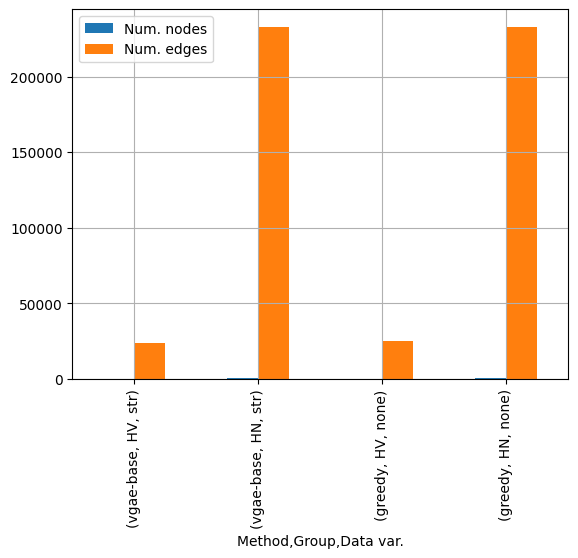

In [42]:
df_results_temp = df_results.set_index(["Method", "Group", "Data var."])
df_results_temp.sort_values(by=["Method", "Group", "Num. edges"], ascending=False, inplace=True)
ax = df_results_temp.plot.bar(rot=90)
ax.grid()

# plt.xticks(rotation=90)
# ax.set_xticklabels(df_results["Method", "Group", "Option"], rotation=90, ha='right')

In [43]:
total = []
nodes = []
edges = []

for i in tqdm(df_results.index[:len(groups_id)]):
    total.append([df_results["Num. nodes"][i], df_results["Num. edges"][i]])
    nodes.append("{} ({}%)".format(df_results["Num. nodes"][i], round(df_results["Num. nodes"][i]*100/df_results["Num. nodes"][i], 2)))
    edges.append("{} ({}%)".format(df_results["Num. edges"][i], round(df_results["Num. edges"][i]*100/df_results["Num. edges"][i], 2)))

index = 0
c = 0
for i in tqdm(df_results.index[len(groups_id):]):
    nodes.append("{} ({}%)".format(df_results["Num. nodes"][i], round(df_results["Num. nodes"][i]*100/total[index][0], 2)))
    edges.append("{} ({}%)".format(df_results["Num. edges"][i], round(df_results["Num. edges"][i]*100/total[index][1], 2)))

    c += 1
    if c % len(data_variations) == 0:
        index = (index + 1) % len(groups_id)

100%|██████████| 2/2 [00:00<00:00, 18040.02it/s]


In [44]:
df_results_ = df_results.copy()
df_results_["Num. nodes"] = nodes
df_results_["Num. edges"] = edges
df_results_.to_csv("output/{}/common_edges/details.csv".format(exp), index=False)
df_results_

,Method,Group,Data var.,Num. nodes,Num. edges
0,greedy,HN,none,688 (100.0%),232669 (100.0%)
1,greedy,HV,none,230 (100.0%),25250 (100.0%)
2,vgae-base,HN,str,688 (100.0%),232820 (100.06%)
3,vgae-base,HV,str,230 (100.0%),23853 (94.47%)


In [45]:
print(df_results_.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format)) 

\begin{tabular}{lllll}
\toprule
Method & Group & Data var. & Num. nodes & Num. edges \\
\midrule
greedy & HN & none & 688 (100.0%) & 232669 (100.0%) \\
greedy & HV & none & 230 (100.0%) & 25250 (100.0%) \\
vgae-base & HN & str & 688 (100.0%) & 232820 (100.06%) \\
vgae-base & HV & str & 230 (100.0%) & 23853 (94.47%) \\
\bottomrule
\end{tabular}

